# Goal:
Analyze and synthesize 2 users' Spotify recent taste profiles so that we can create a playlist filled with brand new song recommendations for both of them to discover together. The playlist we curate will automatically end up in both of their spotify libraries. A novel way for people to socialize because the playlist is unique to them and can create a special experience for both to find new music together that matches their music tastes.

In [659]:
# Import the libraries

import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format ='retina'
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import random
from pandas.io.json import json_normalize

## Authorization Flow

In [660]:
# Declare the credentials

cid = '0b2103231ba64a70885c27fbb38cfa97'
secret = '45d7d10e11474298abcb52df745e2b25'
redirect_uri='http://localhost:7777/callback'
username = 'trustinyoon'

# Authorization flow
scope = 'user-top-read'
token = util.prompt_for_user_token(username, scope, client_id=cid, client_secret=secret, redirect_uri=redirect_uri)

if token:
    sp = spotipy.Spotify(auth=token)
else:
    print("Can't get token for", username)

# Data Collection
## Extract User's Top Medium Term Songs
Spotipy has a built-in function to fetch users' top 50 songs. We extract our songs with that function in the Save_User1_Top_50_Songs.ipynb and Save_User2_Top_50_Songs.ipynb notebooks, and we import the resulting csv files from there below

In [661]:
user1_songs = pd.read_csv('User1_top_50_songs.csv')
user2_songs = pd.read_csv('User2_top_50_songs.csv')
temp = [user1_songs, user2_songs]
temp = pd.concat(temp)
temp.reset_index(drop=True,inplace=True)
temp.head(3)

,Unnamed: 0,artist,artist_uri,song,song_uri,duration_ms,explicit,album,popularity
0,0,Lil Uzi Vert,spotify:artist:4O15NlyKLIASxsJ0PrXPfz,I Can Show You,spotify:track:0AhJag7VI8uFf3mJFsTwvf,120076,True,Eternal Atake (Deluxe) - LUV vs. The World 2,66
1,1,Lil Uzi Vert,spotify:artist:4O15NlyKLIASxsJ0PrXPfz,Myron,spotify:track:56uXDJRCuoS7abX3SkzHKQ,224954,True,Eternal Atake (Deluxe) - LUV vs. The World 2,84
2,2,JACKBOYS,spotify:artist:7A8S43ryYdbWpJKeHRZRcq,GATTI,spotify:track:40mjsnRjCpycdUw3xhS20g,181144,True,JACKBOYS,79


### Extract Users' Top 50 Tracks' Audio Features

In [662]:
user1_list = []
for song in user1_songs['song_uri']:
    row = pd.DataFrame(sp.audio_features(tracks=[song]))
    user1_list.append(row)
user1_df = pd.concat(user1_list)

user2_list = []
for song in user2_songs['song_uri']:
    row = pd.DataFrame(sp.audio_features(tracks=[song]))
    user2_list.append(row)
user2_df = pd.concat(user2_list)

# Combine both users' top 50 songs into one dataframe of 100 songs

dfs = [user1_df, user2_df]
dfs = pd.concat(dfs)
dfs.head(3)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.817,0.656,10,-7.086,0,0.277,0.051,0.0,0.115,0.314,139.915,audio_features,0AhJag7VI8uFf3mJFsTwvf,spotify:track:0AhJag7VI8uFf3mJFsTwvf,https://api.spotify.com/v1/tracks/0AhJag7VI8uF...,https://api.spotify.com/v1/audio-analysis/0AhJ...,120076,4
0,0.771,0.654,8,-6.976,0,0.298,0.055,0.0,0.214,0.573,155.047,audio_features,56uXDJRCuoS7abX3SkzHKQ,spotify:track:56uXDJRCuoS7abX3SkzHKQ,https://api.spotify.com/v1/tracks/56uXDJRCuoS7...,https://api.spotify.com/v1/audio-analysis/56uX...,224955,4
0,0.594,0.676,2,-5.808,1,0.344,0.135,0.0,0.163,0.472,143.477,audio_features,40mjsnRjCpycdUw3xhS20g,spotify:track:40mjsnRjCpycdUw3xhS20g,https://api.spotify.com/v1/tracks/40mjsnRjCpyc...,https://api.spotify.com/v1/audio-analysis/40mj...,181145,4


#### Data Cleaning

In [663]:
# Drop unnecessary features

dfs.drop(['type','track_href','analysis_url','time_signature','duration_ms','uri','instrumentalness','liveness','loudness','key','mode'],1,inplace=True)
dfs.set_index('id',inplace=True)
dfs.head(3)

,danceability,energy,speechiness,acousticness,valence,tempo
id,,,,,,
0AhJag7VI8uFf3mJFsTwvf,0.817,0.656,0.277,0.051,0.314,139.915
56uXDJRCuoS7abX3SkzHKQ,0.771,0.654,0.298,0.055,0.573,155.047
40mjsnRjCpycdUw3xhS20g,0.594,0.676,0.344,0.135,0.472,143.477


In [664]:
# Normalize tempo feature

columns = ['danceability','energy','speechiness','acousticness','valence','tempo']
scaler = MinMaxScaler()
scaler.fit(dfs[columns])
dfs[columns] = scaler.transform(dfs[columns])
dfs.head(3)

,danceability,energy,speechiness,acousticness,valence,tempo
id,,,,,,
0AhJag7VI8uFf3mJFsTwvf,0.856777,0.700288,0.285061,0.056722,0.303797,0.646449
56uXDJRCuoS7abX3SkzHKQ,0.797954,0.698124,0.309083,0.061171,0.577004,0.787933
40mjsnRjCpycdUw3xhS20g,0.571611,0.721928,0.361702,0.150160,0.470464,0.679754


In [665]:
# Check out features summary

dfs.describe()

,danceability,energy,speechiness,acousticness,valence,tempo
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.696637,0.704689,0.203172,0.202933,0.495424,0.463528
std,0.196132,0.178690,0.181131,0.225125,0.235469,0.256441
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.541880,0.587219,0.040809,0.030387,0.335179,0.268585
50%,0.744246,0.725174,0.172958,0.117901,0.470992,0.445405
75%,0.858056,0.851767,0.311656,0.296157,0.667722,0.645888
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Distributions of Combined Audio Features


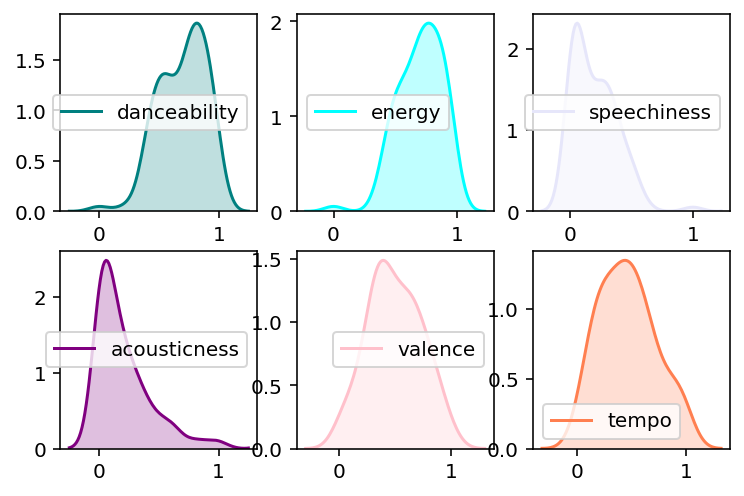

In [666]:
# Visualizing distribution of audio features of our combined songs
print("Distributions of Combined Audio Features")
plt.subplot(2,3,1)
sns.kdeplot(data=dfs.danceability,shade=True,color='teal')
plt.subplot(2,3,2)
sns.kdeplot(data=dfs.energy,shade=True,color='cyan')
plt.subplot(2,3,3)
sns.kdeplot(data=dfs.speechiness,shade=True,color='lavender')
plt.subplot(2,3,4)
sns.kdeplot(data=dfs.acousticness,shade=True,color='purple')
plt.subplot(2,3,5)
sns.kdeplot(data=dfs.valence,shade=True,color='pink')
plt.subplot(2,3,6)
sns.kdeplot(data=dfs.tempo,shade=True,color='coral')

From an initial view, it looks like we collectively tend to enjoy more danceable and energetic songs, but don't listen to many 'speechy' or acoustic songs.

# Building the Song Recommender
## K-Means Cluster Analysis
We used k-means clustering to identify clusters (essentially subgenres) of similar songs in the dataframe that combines all our favorite recent songs together. This would allow us to call the final recommended songs based on the clusters. We chose k=20 since we ideally want 5 songs per cluster to feed into Spotipy's recommendation() function which only takes 5 seed songs. We have tried the elbow method and saw that the ideal k is around 6-8 depending on the users, however, having a larger k will be able curate much more specified subgenres than having a smaller k that groups more songs per cluster.

In [667]:
# Get 20 clusters from 100 songs

clusters = 20
kmeans = KMeans(n_clusters=clusters)
kmeans.fit(dfs)
len(kmeans.labels_)

100

### Plotting and Visualizing Cluster Distances
We want to visualize all the songs in a 3D plot so that we can physically see which songs are close/far from each of their clusters. First, we have to transform our features since there are 6 of them, but we can't plot 6 features on 3 axes, so we use PCA to solve this problem.

In [668]:
from sklearn.decomposition import PCA 

pca = PCA(3) 
pca.fit(dfs) 
  
pca_data = pd.DataFrame(pca.transform(dfs)) 
  
print(pca_data.head())

          0         1         2
0  0.135352  0.100821 -0.184984
1  0.358808  0.030468 -0.048931
2  0.218774  0.152245 -0.047810
3 -0.068135 -0.364285  0.038947
4  0.248385 -0.190958  0.006700


In [669]:
from matplotlib import colors as mcolors 
import math 
   
''' Generating different colors in ascending order  
                                of their hsv values '''
colors = list(zip(*sorted(( 
                    tuple(mcolors.rgb_to_hsv( 
                          mcolors.to_rgba(color)[:3])), name) 
                     for name, color in dict( 
                            mcolors.BASE_COLORS, **mcolors.CSS4_COLORS 
                                                      ).items())))[1] 
   
   
# number of steps to taken generate n(clusters) colors  
skips = math.floor(len(colors[5 : -5])/clusters) 
cluster_colors = colors[5 : -5 : skips] 

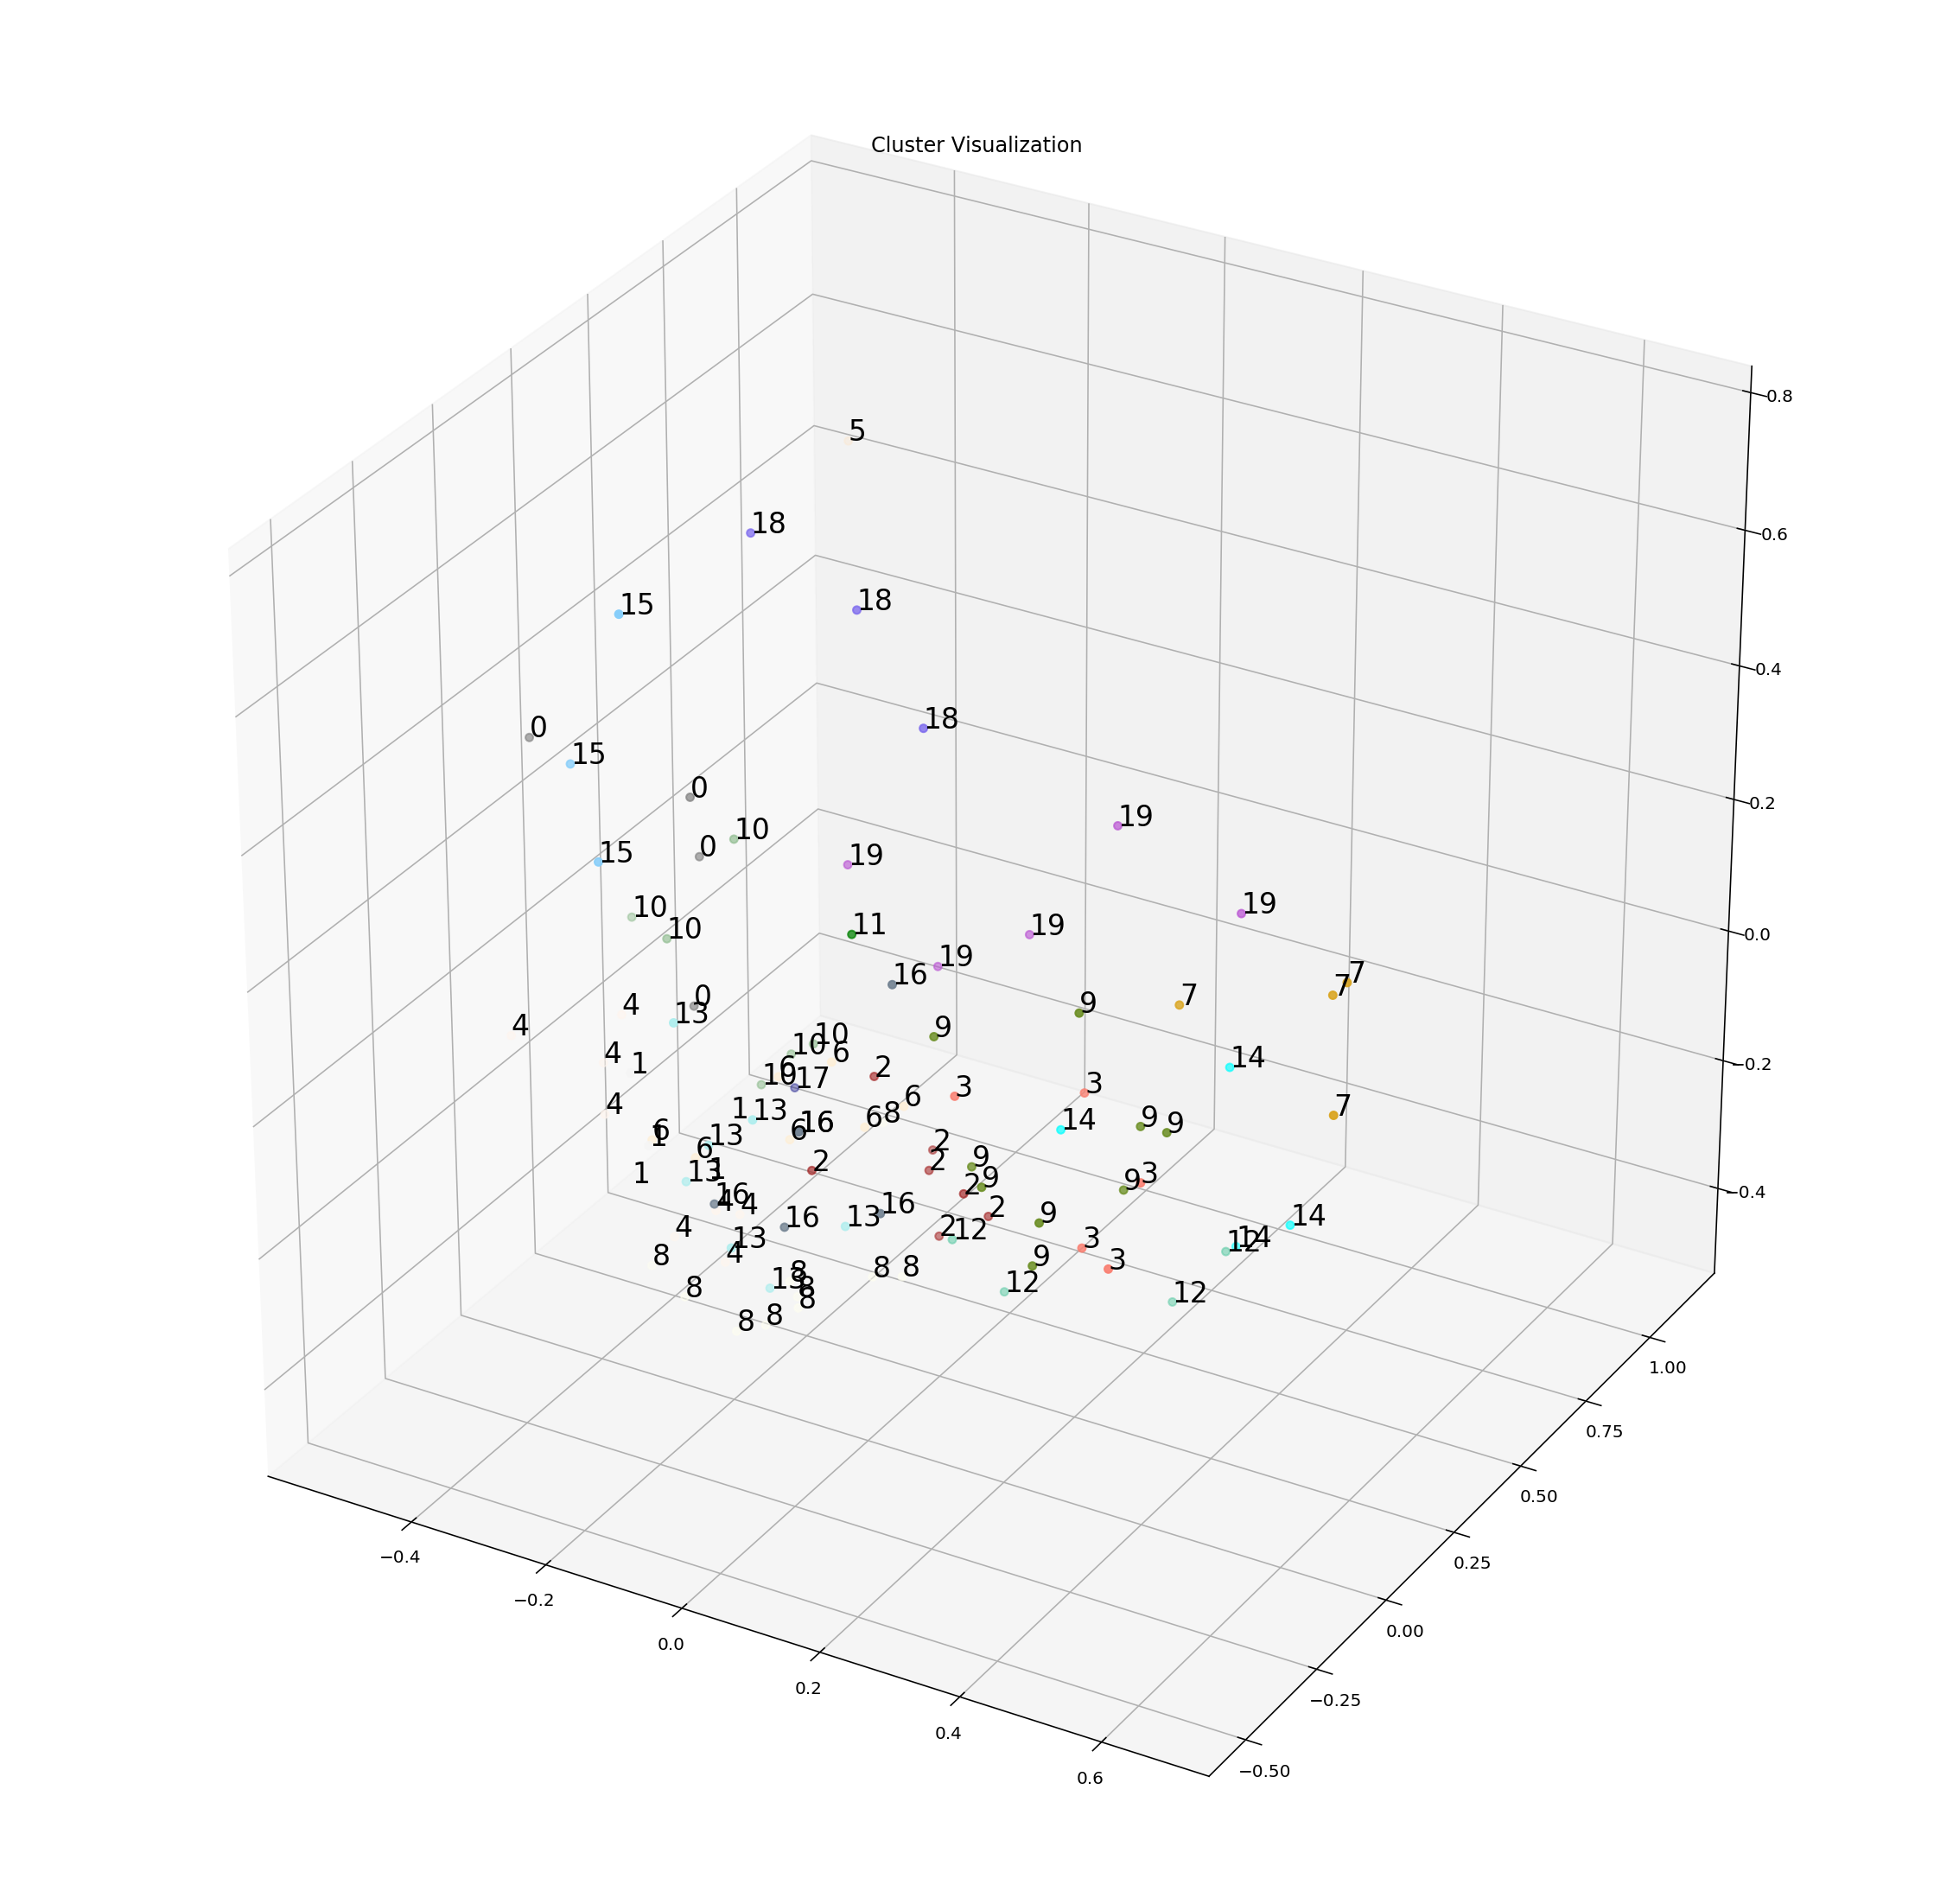

In [691]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt 
   
fig = plt.figure(figsize=(20,20)) 
ax = fig.add_subplot(111, projection = '3d') 
ax.scatter(pca_data[0], pca_data[1], pca_data[2],  
           c = list(map(lambda label : cluster_colors[label], 
                                            kmeans.labels_))) 
   
str_labels = list(map(lambda label:'% s' % label, kmeans.labels_)) 
   
list(map(lambda data1, data2, data3, str_label: 
        ax.text(data1, data2, data3, s = str_label, size = 16.5, 
        zorder = 20, color = 'k'), pca_data[0], pca_data[1], 
        pca_data[2], str_labels)) 
plt.title("Cluster Visualization")
plt.show()

Generally, we can see that each cluster holds a handful of songs that are close in euclidean distance to each other in regards to their features. We can see a few potential outliers from visualizing the clusters in 3D. However, some information is lost since we are using PCA and trying to plot 6 different features onto 3 axes.

### Cluster Analysis
Now that we have visualized and confirmed the clusters correspond to the songs, we should update our dataframe to label each song with its cluster.

In [671]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(dfs)
y_kmeans = kmeans.fit_predict(scaled)
y_kmeans

array([ 2,  9, 14, 13,  9,  5,  4,  9, 13,  0,  2,  2, 16, 19,  4,  7,  3,
        1,  6,  8, 19,  6,  6,  2,  8, 14, 19, 13,  2,  4,  7,  3, 15, 13,
        9,  4,  8,  4,  7,  9,  4, 13, 18, 12, 10,  9,  6, 12, 15,  4,  3,
       16, 16, 19, 14, 10,  8, 10, 16,  0, 16,  3, 10,  9,  1,  6,  8, 11,
       13, 18, 10,  9, 16, 13,  6, 18,  8,  2,  3,  2,  9,  8,  1,  1,  8,
        8,  4, 14,  8,  1,  7, 12, 12, 15,  6, 10, 17,  0, 19,  0],
      dtype=int32)

In [672]:
# Updating dataframe with assigned clusters 

dfs['cluster'] = y_kmeans
dfs['artist'] = temp.artist.tolist()
dfs['title'] = temp.song.tolist()
dfs.head()

,danceability,energy,speechiness,acousticness,valence,tempo,cluster,artist,title
id,,,,,,,,,
0AhJag7VI8uFf3mJFsTwvf,0.856777,0.700288,0.285061,0.056722,0.303797,0.646449,2,Lil Uzi Vert,I Can Show You
56uXDJRCuoS7abX3SkzHKQ,0.797954,0.698124,0.309083,0.061171,0.577004,0.787933,9,Lil Uzi Vert,Myron
40mjsnRjCpycdUw3xhS20g,0.571611,0.721928,0.361702,0.150160,0.470464,0.679754,14,JACKBOYS,GATTI
3hR48Bj9Wgl6xunDG4nsRZ,0.842711,0.865833,0.150080,0.156834,0.695148,0.226896,13,Kid Cudi,Leader Of The Delinquents
4lAQfuREAHG8IC0PiiigBt,0.914322,0.693796,0.374285,0.023017,0.666667,0.564908,9,Lil Uzi Vert,Strawberry Peels (feat. Young Thug & Gunna)


In [673]:
# Checking out the number of songs in each cluster

dfs.groupby('cluster').count()

,danceability,energy,speechiness,acousticness,valence,tempo,artist,title
cluster,,,,,,,,
0,4,4,4,4,4,4,4,4
1,5,5,5,5,5,5,5,5
2,7,7,7,7,7,7,7,7
3,5,5,5,5,5,5,5,5
4,8,8,8,8,8,8,8,8
5,1,1,1,1,1,1,1,1
6,7,7,7,7,7,7,7,7
7,4,4,4,4,4,4,4,4
8,10,10,10,10,10,10,10,10


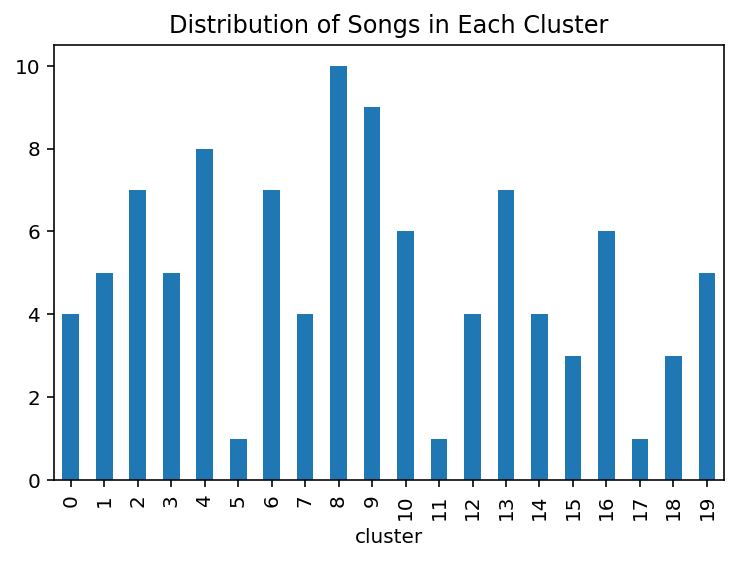

In [674]:
plt.title("Distribution of Songs in Each Cluster")
dfs.groupby('cluster').count().danceability.plot.bar()

#### Visualizing different clusters' features
Let's start by comparing each cluster's features on a bar plot grid.

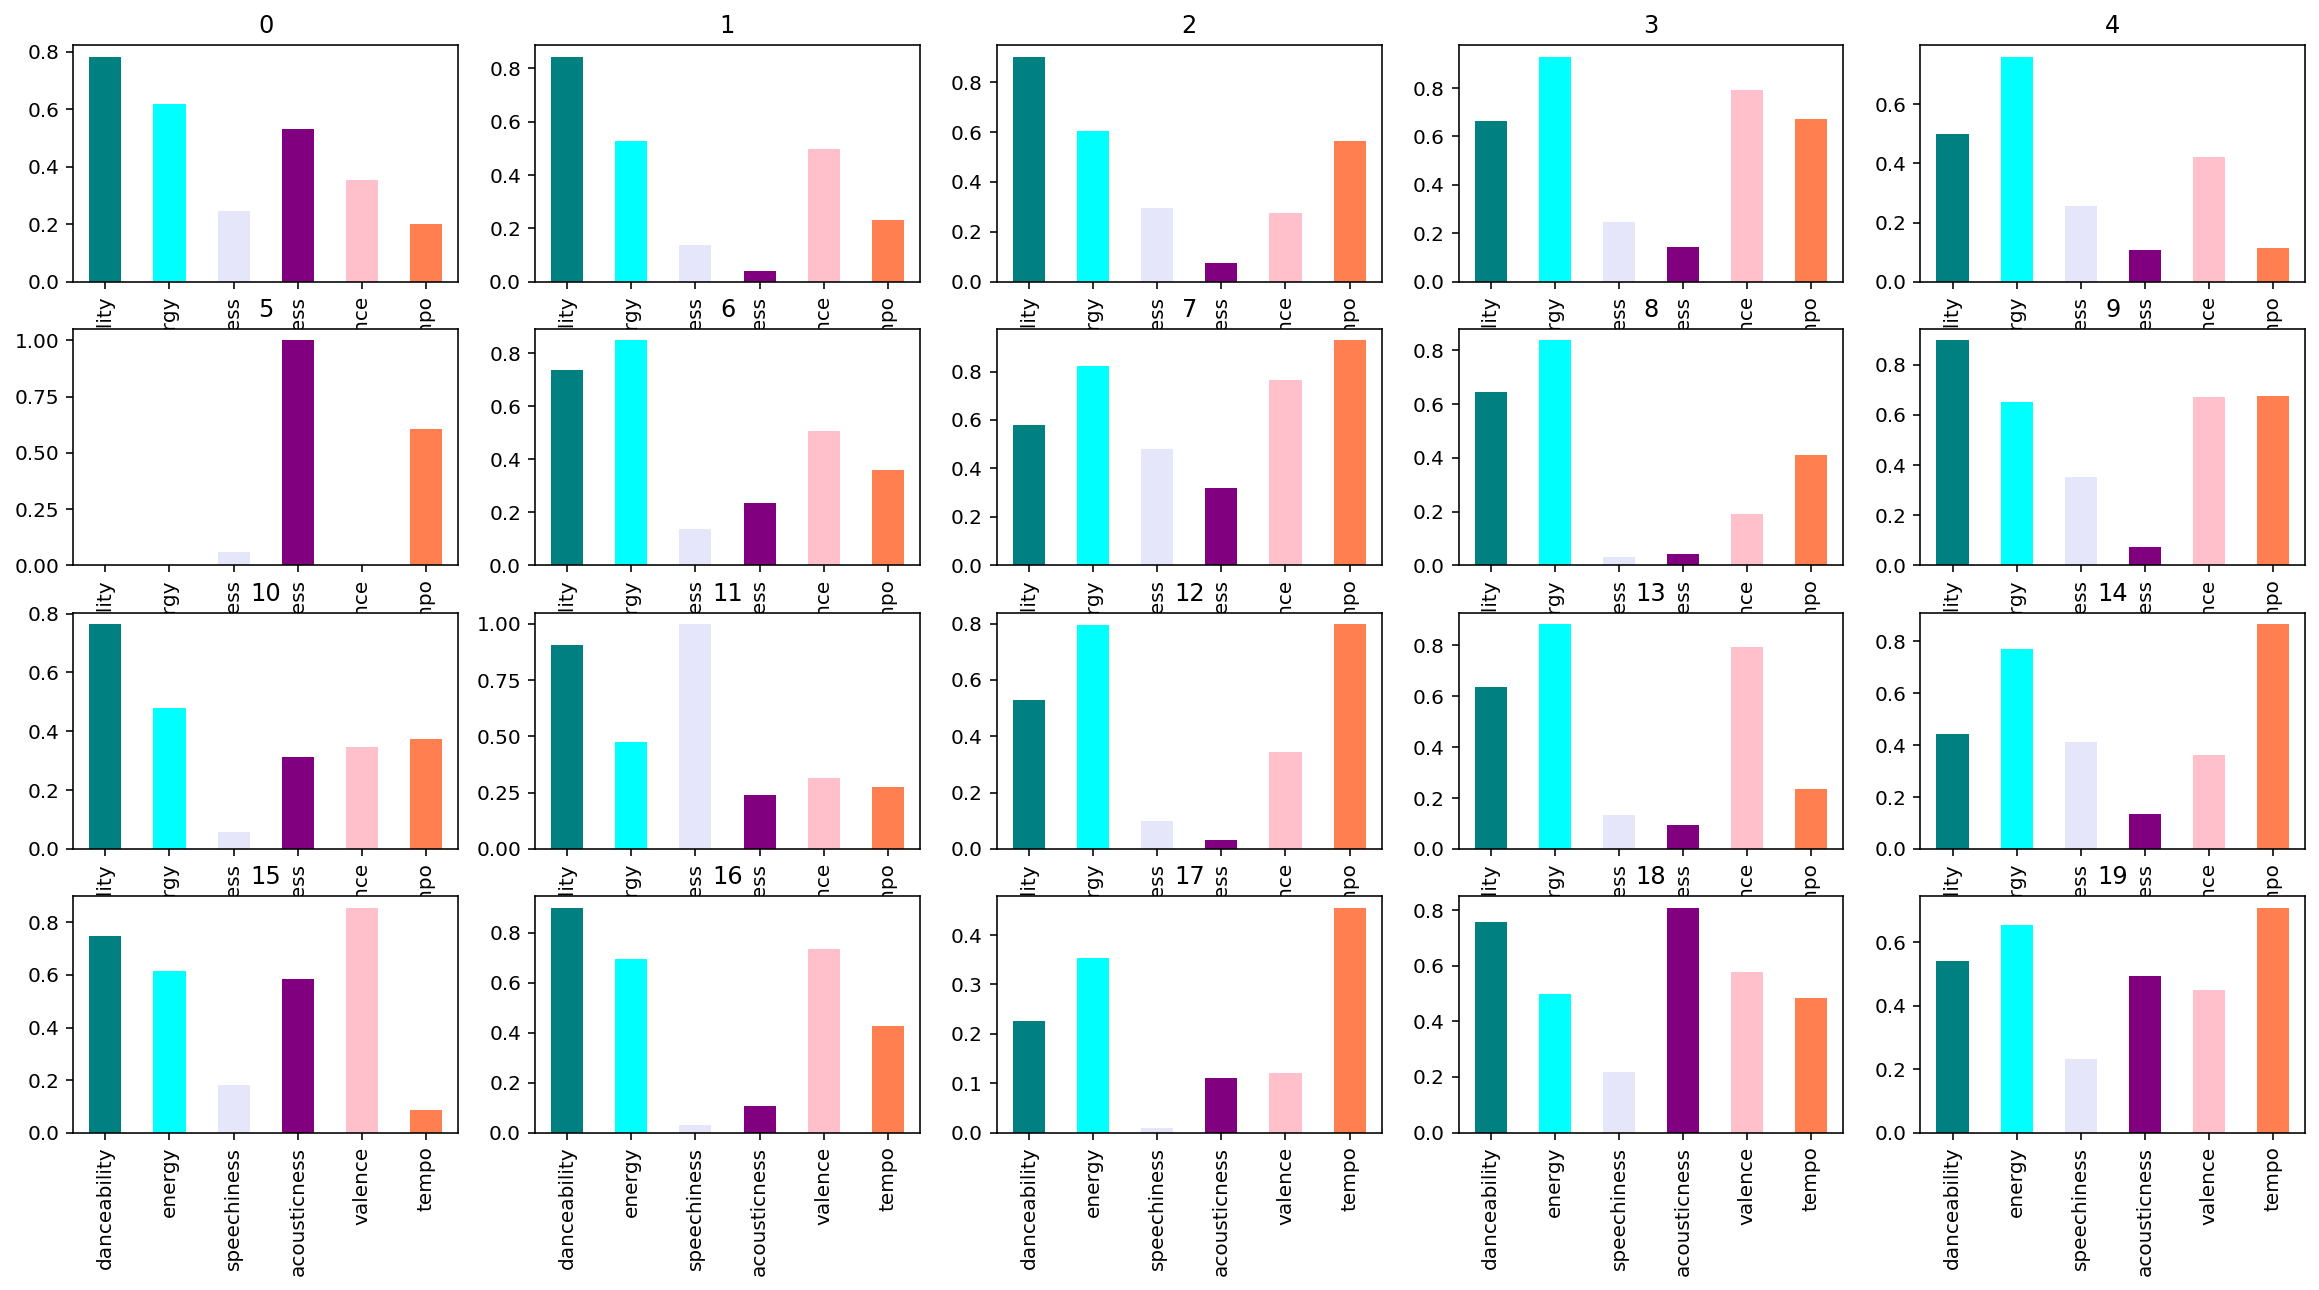

In [675]:
i=0
fig=plt.figure(figsize=(20,10))
while i<20:
    plt.subplot(4,5,i+1)
    dfs.loc[dfs.cluster==i].mean().drop('cluster').plot.bar(color=['teal','cyan','lavender','purple','pink','coral'])
    plt.title(str(i))
    i+=1

One problem we have is that there are clusters with only one song in them, which means that it does not have favorable qualities shared by the both of us. (Note that cluster 5 is mostly blank since one of my top 50 songs is a track that is literally just white noise that I use to fall asleep everyday, and it was made into its own cluster). So we will remove clusters with only one song for our recommender

In [676]:
# Removing clusters that only have one song in them

delete_clusters = []
cluster = 0
while cluster < (len(dfs.cluster.unique())-1):
    if dfs.groupby('cluster').count().loc[cluster].danceability == 1:
        delete_clusters.append(cluster)
    cluster+=1
    
delete_clusters

[5, 11, 17]

In [677]:
dfs.reset_index(inplace=True)

In [678]:
i = 0
while i < (len(dfs.cluster.unique())-1):
    if dfs.loc[[i]].cluster.tolist()[0] in delete_clusters:
        dfs.drop(i,0,inplace=True)
    i+=1

In [679]:
dfs.set_index('id',inplace=True)

Now we want to make a nested list so that it contains a list of songs for every cluster. The purpose of this is so that we can find 1-2 recommended songs for each cluster using spotipy's built-in recommendations() function that takes in 5 seed songs.

In [680]:
# Create list of lists of song ids to put into recommendation function

i=0
list_of_recs = [0]*len(dfs.groupby('cluster').count())
while i<len(dfs.groupby('cluster').count()):
    list_of_recs[i] = dfs.loc[dfs['cluster'] == i].index.to_list()
    i+=1

list_of_recs = [ele for ele in list_of_recs if ele != []] 
len(list_of_recs)

18

In [681]:
# Adjust list for clusters so that each cluster has a maximum of 5 seed songs

j = 0
adj_list_of_recs = [0]*len(list_of_recs)
while j<len(list_of_recs):
    if 0 < len(list_of_recs[j]) < 6:
        adj_list_of_recs[j] = list_of_recs[j]
    elif len(list_of_recs[j]) > 5:
        adj_list_of_recs[j] = random.sample(list_of_recs[j], 5)
    j += 1

len(adj_list_of_recs)

18

We want to get 1 recommended song from each cluster with less than 4 songs and 2 recommended songs from each cluster with 4-5 songs. This is because we assume that bigger clusters generally mean that we enjoy songs similar to that cluster more. We give weight to the song recommender to accomodate for this preference towards bigger clusters.

In [682]:
#Getting 1 recommended song from each cluster with less than 4 songs, 2 recommended songs from each cluster with 4-5 songs

k = 0
list_of_recommendations = [0]*len(list_of_recs)
while k < len(list_of_recs):
    if len(adj_list_of_recs[k]) < 4:
        list_of_recommendations[k] = sp.recommendations(seed_tracks=adj_list_of_recs[k],limit=1)
    else:
        list_of_recommendations[k] = sp.recommendations(seed_tracks=adj_list_of_recs[k],limit=2)
    k += 1
    
pd.json_normalize(list_of_recommendations[15], record_path='tracks').id

0    3QHPHLAkYV5cQBUYs6rowx
1    3Zcv9IeYgCvEhxFTfsduaQ
Name: id, dtype: object

In [683]:
list_of_recommendations_converted = [0]*len(list_of_recs)

l = 0
while l < len(list_of_recs):
    list_of_recommendations_converted.append(pd.json_normalize(list_of_recommendations[l], record_path='tracks').id.tolist())
    l += 1

no_integers = [x for x in list_of_recommendations_converted if not isinstance(x, int)]
list_of_recommendations_converted = [item for elem in no_integers for item in elem]

len(list_of_recommendations_converted)

32

## Create the New Playlist
Next, we are going to create a new playlist and add to it all the tracks we ended up selecting:

In [684]:
# Authorization flow

scope = "playlist-modify-public"
token = util.prompt_for_user_token(username, scope, client_id=cid, client_secret=secret, redirect_uri=redirect_uri)

if token:
    sp = spotipy.Spotify(auth=token)
else:
    print("Can't get token for", username)

In [685]:
# Create new playlist and insert it straight to user's library

def create_playlist(sp, username, playlist_name, playlist_description):
    playlists = sp.user_playlist_create(username, playlist_name, description = playlist_description)

In [686]:
create_playlist(sp, username, 'Spotify Discover Together', 'Choose a friend to discover brand new music with. We create an adventurous playlist curated to both of your tastes!')

In [687]:
# Fetch user's playlist library

def fetch_playlists(sp, username):
    """
    Returns the user's playlists.
    """
        
    id = []
    name = []
    num_tracks = []
    
    # Make the API request
    playlists = sp.user_playlists(username)
    for playlist in playlists['items']:
        id.append(playlist['id'])
        name.append(playlist['name'])
        num_tracks.append(playlist['tracks']['total'])

    # Create the final df   
    df_playlists = pd.DataFrame({"id":id, "name": name, "#tracks": num_tracks})
    return df_playlists

In [688]:
# Find the new playlist's id

fetch_playlists(sp,username).head(3)

,id,name,#tracks
0,0M13hCbRZvEJ9MIoiWkXaF,Spotify Discover Together,0
1,1MN9exZnFBWeeQAvUNq0z8,Spotify Discover Together,32
2,0V4FzMOSwDfXefUZMfB5ou,여,76


In [689]:
extracted_id = fetch_playlists(sp,username).id[0]

In [690]:
# Finally, fill the new playlist with the recommended songs straight to the user's library!

sp.user_playlist_add_tracks(username, extracted_id, list_of_recommendations_converted, position=None)

{'snapshot_id': 'Myw1ZWMyMDBiZjE3YzI3ZTFjYmUxYzJhYmU2OWVhYmM5Nzg1MjJjZDhm'}